In [1]:
import discogs_client
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np

# Import multiprocessing libraries
from concurrent.futures import ThreadPoolExecutor

import multiprocessing

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from typing import Dict, List, Tuple, Optional, Set
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

# Additional imports
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from functools import partial

In [2]:
# Spotify & Discogs Client Credentials
CLIENT_ID = "26c65df3e5844f1dbe355d82d80c9f6f"
CLIENT_SECRET = "2d4d2b147bc942b999564a5e8649b987"
DISCOGS_TOKEN = "FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX"

In [3]:
#Initialize SpotiPy with user credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID,
                                                           client_secret=CLIENT_SECRET))

In [4]:
#Initialize Discogs_client with user credentials

d = discogs_client.Client(
    'my_user_agent/1.0',
    consumer_key='hZZUdNwRHsUxlgReVdCA',
    consumer_secret='TUAxCaABSkDcmQgeRhIbRRvnHAopOIkH',
    token=u'FbbkQDyGoGsJlnSqVfFwqfvUWnrtDcBiWmyHOHjX',
    secret=u'my_token_secret'
)

In [5]:
#d.get_authorize_url()
#d.get_access_token("FJwsqclHeX")
#me = d.identity()
#print(me)
#release = d.release(30690634).styles
#print(release)

In [ ]:
# Music Recommender Appplication

def calculate_style_similarity(input_styles: List[str], ref_styles: str) -> float:
    """Calculate style similarity between input styles and reference styles."""
    try:
        ref_styles_list = [s.strip().lower() for s in ref_styles.split(',')]
        input_styles_set = set(s.lower() for s in input_styles)
        matches = input_styles_set.intersection(ref_styles_list)
        return len(matches) / max(len(input_styles_set.union(ref_styles_list)), 1)
    except Exception as e:
        print(f"Error in style similarity calculation: {e}")
        return 0.0

def _normalize_bpm(bpm: float) -> float:
    """Normalize BPM to standard range."""
    try:
        if pd.isna(bpm) or bpm <= 0:
            return -1
        bpm = float(bpm)
        while bpm < 80:
            bpm *= 2
        while bpm > 160:
            bpm /= 2
        return bpm
    except Exception as e:
        print(f"Error normalizing BPM {bpm}: {str(e)}")
        return -1

def analyze_bpm_compatibility(args):
    """Calculate BPM compatibility score between two tracks."""
    bpm1, bpm2 = args
    try:
        if pd.isna(bpm1) or pd.isna(bpm2) or bpm1 <= 0 or bpm2 <= 0:
            return 0.5  # Default compatibility for invalid BPMs
        # Normalize both BPMs
        bpm1_norm = _normalize_bpm(float(bpm1))
        bpm2_norm = _normalize_bpm(float(bpm2))
        # Calculate absolute difference
        diff = abs(bpm1_norm - bpm2_norm)
        # Score based on difference
        if diff <= 2:
            return 1.0    # Perfect match
        elif diff <= 4:
            return 0.9    # Very good match
        elif diff <= 6:
            return 0.8    # Good match
        elif diff <= 8:
            return 0.7    # Decent match
        elif diff <= 10:
            return 0.6    # Acceptable match
        else:
            # Decreasing compatibility for larger differences
            return max(0.2, 1 - (diff * 0.05))
    except Exception as e:
        print(f"Error in BPM compatibility analysis: {e}")
        return 0.5  # Default compatibility score on error

def check_key_compatibility(args):
    """Calculate compatibility score between two musical keys."""
    key1, key2, mode1, mode2, compatible_keys = args
    try:
        if key1 == -1 or key2 == -1:
            return 0.5
        if key1 == key2 and mode1 == mode2:
            return 1.0
        if key2 in compatible_keys.get(key1, []):
            return 0.8 if mode1 == mode2 else 0.7
        steps = min((key1 - key2) % 12, (key2 - key1) % 12)
        base_score = max(0.2, 1 - (steps * 0.1))
        return base_score * 0.9 if mode1 != mode2 else base_score
    except Exception as e:
        print(f"Error in key compatibility calculation: {e}")
        return 0.5

# Global variables for parallel processing functions
COMPATIBLE_KEYS = {
    -1: list(range(12)),
    0: [11, 1, 5],
    1: [0, 2, 6],
    2: [1, 3, 7],
    3: [2, 4, 8],
    4: [3, 5, 9],
    5: [4, 6, 10],
    6: [5, 7, 11],
    7: [6, 8, 0],
    8: [7, 9, 1],
    9: [8, 10, 2],
    10: [9, 11, 3],
    11: [10, 0, 4]
}

class MusicRecommender:
    def __init__(self, spotify_client_id: str, spotify_client_secret: str, discogs_token: str):
        """Initialize the recommender with API credentials."""
        # Initialize Spotify client
        self.spotify = spotipy.Spotify(
            client_credentials_manager=SpotifyClientCredentials(
                client_id=spotify_client_id,
                client_secret=spotify_client_secret
            )
        )
        
        # Initialize Discogs client
        self.discogs = discogs_client.Client(
            'MusicRecommender/1.0',
            user_token=discogs_token
        )
        
        # Define audio features for analysis
        self.audio_features = [
            'danceability', 'energy', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence'
        ]
        self.all_features = self.audio_features + ['tempo', 'key', 'mode']
        
        # Define clustering parameters
        self.n_clusters = 8
        self.clustering_features = self.all_features.copy()
        self.clustering_features.remove('mode')  # Mode is categorical, exclude from clustering
        self.clustering_features.append('tempo_normalized')
        
        # Initialize components
        self.initialize_musical_keys()
        self.initialize_genre_mapping()
        
        # Number of CPU cores for parallel processing
        self.n_cores = multiprocessing.cpu_count()
        
        # Load and prepare reference dataset
        try:
            self.reference_df = pd.read_csv('complete/spotify_complete_data.csv')
            print(f"Successfully loaded dataset with {len(self.reference_df)} tracks")
            
            # Process musical features
            self.process_musical_features()
            # Initialize clustering
            self._initialize_clustering()
        except FileNotFoundError:
            raise FileNotFoundError("Could not find spotify_complete_data.csv")
        except Exception as e:
            raise Exception(f"Error processing dataset: {str(e)}")
    
    def initialize_musical_keys(self):
        """Initialize musical key mappings and relationships."""
        # Spotify key notation (Camelot compatible)
        self.key_map = {
            -1: ['--', 'Unknown'],
            0: ['8B', 'C'],
            1: ['3B', 'C#/Db'],
            2: ['10B', 'D'],
            3: ['5B', 'D#/Eb'],
            4: ['12B', 'E'],
            5: ['7B', 'F'],
            6: ['2B', 'F#/Gb'],
            7: ['9B', 'G'],
            8: ['4B', 'G#/Ab'],
            9: ['11B', 'A'],
            10: ['6B', 'A#/Bb'],
            11: ['1B', 'B']
        }
        
        # Mapping for minor keys
        self.key_map_minor = {
            -1: ['--', 'Unknown'],
            0: ['8A', 'Am'],
            1: ['3A', 'A#m/Bbm'],
            2: ['10A', 'Bm'],
            3: ['5A', 'Cm'],
            4: ['12A', 'C#m/Dbm'],
            5: ['7A', 'Dm'],
            6: ['2A', 'D#m/Ebm'],
            7: ['9A', 'Em'],
            8: ['4A', 'Fm'],
            9: ['11A', 'F#m/Gbm'],
            10: ['6A', 'Gm'],
            11: ['1A', 'G#m/Abm']
        }
        
        # Key compatibility matrix
        self.compatible_keys = COMPATIBLE_KEYS
    
    def get_full_key(self, key: int, mode: int) -> str:
        """Get full key name including mode."""
        if key == -1:
            return "Unknown"
        return self.key_map[key][1] if mode == 1 else self.key_map_minor[key][1]
    
    def process_musical_features(self):
        """Process and normalize musical features in reference dataset."""
        try:
            # Process tempo/BPM
            if 'tempo' in self.reference_df.columns:
                self.reference_df['tempo'] = self.reference_df['tempo'].fillna(-1)
                # Add normalized tempo column
                self.reference_df['tempo_normalized'] = self.reference_df['tempo'].apply(
                    lambda x: _normalize_bpm(float(x))
                )
            else:
                self.reference_df['tempo'] = -1
                self.reference_df['tempo_normalized'] = -1

            # Process key information
            if 'key' in self.reference_df.columns:
                self.reference_df['key'] = self.reference_df['key'].fillna(-1).astype(int)
            else:
                self.reference_df['key'] = -1

            if 'mode' in self.reference_df.columns:
                self.reference_df['mode'] = self.reference_df['mode'].fillna(1).astype(int)
            else:
                self.reference_df['mode'] = 1

            # Create full key representation
            self.reference_df['key_full'] = self.reference_df.apply(
                lambda row: self.get_full_key(row['key'], row['mode']),
                axis=1
            )

            # Normalize all features for clustering
            features_to_normalize = self.audio_features

            # Ensure all required features exist
            for feature in features_to_normalize:
                if feature not in self.reference_df.columns:
                    self.reference_df[feature] = 0

            print("Available features after processing:", self.reference_df.columns.tolist())
        except Exception as e:
            print(f"Error in process_musical_features: {str(e)}")
            raise
    
    def initialize_genre_mapping(self):
        """Initialize comprehensive mappings between Discogs styles and electronic music genres."""
        self.style_mappings = {
            # Techno and related styles
            'techno': [
                'techno', 'detroit techno', 'minimal techno', 'acid techno', 
                'industrial techno', 'dub techno', 'hard techno', 'experimental techno',
                'tech house', 'minimal', 'loops & samples', 'tribal', 'warehouse techno',
                'peak time techno', 'hypnotic techno', 'raw techno', 'atmospheric techno',
                'melodic techno', 'broken techno', 'techno industrial'
            ],
            
            # House and related styles
            'house': [
                'house', 'deep house', 'tech house', 'acid house', 'minimal house',
                'progressive house', 'tribal house', 'disco house', 'funky house',
                'chicago house', 'microhouse', 'electro house', 'minimal/tech house',
                'soulful house', 'vocal house', 'garage house', 'filter house',
                'melodic house', 'jackin house', 'raw house', 'ghetto house'
            ],
            
            # Ambient and atmospheric
            'ambient': [
                'ambient', 'dark ambient', 'atmospheric', 'drone', 'soundscape',
                'experimental ambient', 'space ambient', 'ambient techno', 
                'ambient dub', 'downtempo', 'chill out', 'isolationist',
                'fourth world', 'environmental', 'ethereal', 'cinematic ambient',
                'cosmic', 'abstract ambient', 'ambient industrial'
            ],
            
            # Drum and Bass / Jungle
            'drum and bass': [
                'drum and bass', 'dnb', 'jungle', 'atmospheric dnb', 'darkstep',
                'neurofunk', 'jump up', 'liquid funk', 'breakcore', 'intelligent dnb',
                'techstep', 'hardstep', 'drumfunk', 'ragga jungle', 'crossbreed',
                'minimal dnb', 'deep dnb', 'dark dnb', 'roller', 'half time'
            ],
            
            # Dub and related
            'dub': [
                'dub', 'dub techno', 'deep dub', 'ambient dub', 'dubstep',
                'dub house', 'reggae', 'minimal dub', 'tech dub',
                'dub ambient', 'abstract dub', 'dubbed out', 'steppers',
                'roots', 'digi dub', 'uk dub', 'space dub'
            ],
            
            # IDM and Experimental
            'idm': [
                'idm', 'braindance', 'experimental', 'glitch', 'microsound',
                'algorithmic', 'generative', 'sound art', 'avant-garde',
                'musique concrète', 'electroacoustic', 'computer music',
                'granular synthesis', 'field recording', 'modular'
            ],
            
            # Breakbeat and Related
            'breakbeat': [
                'breakbeat', 'breaks', 'nu breaks', 'progressive breaks',
                'electro breaks', 'acid breaks', 'breakcore', 'big beat',
                'florida breaks', 'nu skool breaks', 'chemical breaks',
                'funky breaks', 'tech breaks'
            ]
        }
        
        # Additional style characteristics
        self.style_characteristics = {
            'deep': ['deep house', 'deep techno', 'deep dub', 'deep minimal', 'deep dnb'],
            'progressive': ['progressive house', 'progressive trance', 'progressive breaks'],
            'tribal': ['tribal house', 'tribal techno', 'tribal ambient'],
            'dark': ['dark ambient', 'darkstep', 'dark techno', 'dark progressive'],
            'hypnotic': ['hypnotic techno', 'hypnotic minimal', 'hypnotic dub'],
            'atmospheric': ['atmospheric dnb', 'atmospheric techno', 'atmospheric ambient'],
            'minimal': ['minimal techno', 'minimal house', 'minimal dub', 'minimal dnb'],
            'experimental': ['experimental techno', 'experimental house', 'experimental electronic']
        }
        
        # BPM ranges for genres
        self.genre_bpm_ranges = {
            'techno': (125, 140),
            'house': (120, 130),
            'drum and bass': (160, 180),
            'dubstep': (140, 150),
            'ambient': (60, 120),
            'downtempo': (80, 110),
            'breakbeat': (120, 150),
            'idm': (80, 160),
            'minimal': (125, 130)
        }
    
    def parse_discogs_url(self, url: str) -> Tuple[str, int]:
        """Parse Discogs URL to extract release type and ID."""
        master_pattern = r'/master/(\d+)'
        release_pattern = r'/release/(\d+)'
        
        master_match = re.search(master_pattern, url)
        if master_match:
            return 'master', int(master_match.group(1))
            
        release_match = re.search(release_pattern, url)
        if release_match:
            return 'release', int(release_match.group(1))
            
        raise ValueError("Invalid Discogs URL format")

    def get_discogs_info(self, url: str) -> Dict:
        """Get detailed release information from Discogs."""
        release_type, release_id = self.parse_discogs_url(url)
        
        try:
            if release_type == 'master':
                master = self.discogs.master(release_id)
                release = master.main_release
            else:
                release = self.discogs.release(release_id)
            
            # Extract basic information
            info = {
                'artist': release.artists[0].name if release.artists else "Unknown Artist",
                'album': release.title if release.title else "Unknown Album",
                'tracks': [track.title for track in release.tracklist 
                          if track.title and isinstance(track.title, str)],
                'genres': release.genres if hasattr(release, 'genres') else [],
                'styles': release.styles if hasattr(release, 'styles') else [],
                'year': release.year if hasattr(release, 'year') else None,
                'label': release.labels[0].name if release.labels else "Unknown Label",
                'catalog': release.labels[0].catno if release.labels else "Unknown",
                'format': release.formats[0]['name'] if release.formats else "Unknown Format"
            }
            
            # Clean up artist name
            info['artist'] = re.sub(r'\(\d+\)', '', info['artist']).strip()
            
            # Get price statistics through web scraping
            price_stats = self._scrape_price_stats(url)
            info.update(price_stats)
            
            return info
            
        except Exception as e:
            print(f"Failed to fetch Discogs release: {str(e)}")
            return {
                'artist': 'Unknown Artist',
                'album': 'Unknown Album',
                'tracks': [],
                'genres': [],
                'styles': [],
                'year': None,
                'label': 'Unknown Label',
                'catalog': 'Unknown',
                'format': 'Unknown Format'
            }
    
    def _scrape_price_stats(self, url: str) -> Dict:
        """Scrape price statistics from Discogs webpage using Selenium."""
        # Set Chrome options (you can enable headless mode if desired)
        chrome_options = Options()
        #chrome_options.add_argument("--headless")
        
        # Initialize WebDriver using WebDriver Manager
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
        
        try:
            # Load the Discogs release page
            driver.get(url)
            
            # Wait for the "release-stats" section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "release-stats"))
            )
            
            # Locate the price statistics section
            price_section = driver.find_element(By.ID, "release-stats")

            # Initialize a dictionary to store price data
            price_info = {'low': None, 'median': None, 'high': None}

            # Locate all <li> elements in the price section containing price stats
            li_elements = price_section.find_elements(By.TAG_NAME, "li")
            
            for li in li_elements:
                # Each <li> should have two spans: one for the label, one for the value
                spans = li.find_elements(By.TAG_NAME, "span")
                if len(spans) == 2:
                    label = spans[0].text.strip().lower()
                    value = spans[1].text.strip()

                    # Map the label to the appropriate field in price_info
                    if 'low' in label:
                        price_info['low'] = value
                    elif 'median' in label:
                        price_info['median'] = value
                    elif 'high' in label:
                        price_info['high'] = value
            
            return price_info

        except Exception as e:
            print(f"Error scraping prices with Selenium: {e}")
            return {'low': None, 'median': None, 'high': None}
        
        finally:
            # Close the Selenium driver
            driver.quit()

    def visualize_album_features(self, tracks_features: List[Dict]) -> None:
        """Create visualizations for album audio features and track tempos."""
        # Define features for spider plot (explicitly exclude loudness)
        spider_features = [
            'danceability', 'energy', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence'
        ]
        
        # Calculate mean features for radar plot
        mean_features = pd.DataFrame(tracks_features)[spider_features].mean()
        
        # Normalize values between 0 and 1 for radar plot
        scaler = MinMaxScaler()
        mean_features_scaled = pd.Series(
            scaler.fit_transform(mean_features.values.reshape(-1, 1)).flatten(),
            index=mean_features.index
        )
        
        # Create figure with subplots
        plt.figure(figsize=(15, 6))
        
        # Radar plot for audio features
        ax1 = plt.subplot(121, projection='polar')
        angles = np.linspace(0, 2*np.pi, len(spider_features), endpoint=False)
        values = mean_features_scaled.values
        values = np.concatenate((values, [values[0]]))  # Complete the polygon
        angles = np.concatenate((angles, [angles[0]]))
        
        ax1.plot(angles, values)
        ax1.fill(angles, values, alpha=0.25)
        ax1.set_xticks(angles[:-1])
        ax1.set_xticklabels(spider_features)
        ax1.set_ylim(0, 1)  # Set fixed scale 0-1
        ax1.set_title("Audio Features Profile")
        
        # Track tempos horizontal bar chart
        ax2 = plt.subplot(122)
        track_data = pd.DataFrame(tracks_features)
        
        # Sort by tempo for better visualization
        track_data = track_data.sort_values('tempo')
        
        # Create horizontal bar chart
        ax2.barh(track_data['name'], track_data['tempo'])
        ax2.set_xlabel('Tempo (BPM)')
        ax2.set_title('Track Tempos')
        
        # Adjust layout and display
        plt.tight_layout()
        plt.show()

    def get_spotify_features(self, artist: str, album: str) -> Optional[Dict]:
        """Get Spotify audio features and metadata for an album."""
        try:
            # Search for album
            query = f"album:{album} artist:{artist}"
            results = self.spotify.search(q=query, type='album', limit=1)
            
            # If no results, try searching only by album name
            if not results['albums']['items']:
                print("Initial search failed, trying without artist...")
                query = f"album:{album}"
                results = self.spotify.search(q=query, type='album', limit=1)
                if not results['albums']['items']:
                    return None  # Album not found
                
            album_id = results['albums']['items'][0]['id']
            album_info = self.spotify.album(album_id)
            
            # Get tracks and their audio features
            tracks = self.spotify.album_tracks(album_id)['items']
            track_ids = [track['id'] for track in tracks]
            audio_features = self.spotify.audio_features(track_ids)
            
            # Combine track info with audio features
            tracks_with_features = []
            for track, features in zip(tracks, audio_features):
                if features:
                    track_info = {
                        'name': track['name'],
                        'preview_url': track['preview_url'],
                        'duration_ms': track['duration_ms'],
                        **{k: features[k] for k in self.all_features}
                    }
                    tracks_with_features.append(track_info)
            
            # Handle case where there are no tracks with features
            if not tracks_with_features:
                return None
            
            return {
                'album_image': album_info['images'][0]['url'] if album_info['images'] else None,
                'tracks': tracks_with_features
            }
            
        except Exception as e:
            print(f"Error getting Spotify features: {e}")
            return None
    
    def _initialize_clustering(self):
        """Initialize and fit clustering model on reference dataset."""
        try:
            # Ensure all required features exist
            clustering_features = self.clustering_features
            
            # Create feature DataFrame for clustering
            features_df = self.reference_df[clustering_features].copy()
            
            # Fill any missing values
            features_df = features_df.fillna(features_df.mean())
            
            # Normalize features
            self.scaler = StandardScaler()
            features_scaled = self.scaler.fit_transform(features_df)
            
            # Perform PCA for dimensionality reduction
            self.pca = PCA(n_components=3)
            features_pca = self.pca.fit_transform(features_scaled)
            
            # Fit KMeans clustering
            self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
            self.reference_df['cluster'] = self.kmeans.fit_predict(features_scaled)
            
            # Store transformed features
            self.reference_df['pca1'] = features_pca[:, 0]
            self.reference_df['pca2'] = features_pca[:, 1]
            self.reference_df['pca3'] = features_pca[:, 2]
            
            print(f"Initialized clustering with {self.n_clusters} clusters")
            self._analyze_clusters()
        except Exception as e:
            print(f"Error in clustering initialization: {str(e)}")
            raise

    def _analyze_clusters(self):
        """Analyze characteristics of each cluster."""
        self.cluster_profiles = {}
        
        for cluster in range(self.n_clusters):
            cluster_data = self.reference_df[self.reference_df['cluster'] == cluster]
            
            # Calculate mean features for cluster
            profile = cluster_data[self.clustering_features].mean()
            
            # Find dominant characteristics
            dominant_features = []
            for feature in self.clustering_features:
                mean_val = profile[feature]
                if abs(mean_val) > 0.5:  # Significant deviation from mean
                    direction = "high" if mean_val > 0 else "low"
                    dominant_features.append(f"{direction} {feature}")
            
            self.cluster_profiles[cluster] = {
                'features': profile,
                'size': len(cluster_data),
                'dominant_features': dominant_features
            }

    def find_similar_tracks(self, tracks_features: List[Dict], input_styles: List[str], 
                            n_recommendations: int = 5) -> pd.DataFrame:
        """Find similar tracks using clustering and feature matching."""
        try:
            # Create DataFrame for input tracks and ensure all required features
            input_df = pd.DataFrame(tracks_features)
            
            # Define required features
            required_features = self.all_features + ['tempo_normalized']
            
            # Check and fill missing features
            for feature in required_features:
                if feature not in input_df.columns:
                    print(f"Warning: Missing feature {feature} in input tracks")
                    input_df[feature] = 0
            
            # Add normalized tempo
            input_df['tempo_normalized'] = input_df['tempo'].apply(
                lambda x: _normalize_bpm(float(x))
            )
            
            # Ensure reference dataset has normalized tempo
            if 'tempo_normalized' not in self.reference_df.columns:
                self.reference_df['tempo_normalized'] = self.reference_df['tempo'].apply(
                    lambda x: _normalize_bpm(float(x))
                )
            
            # Calculate mean features of input tracks
            clustering_features = self.clustering_features
            
            input_cluster_features = input_df[clustering_features]
            input_mean = input_cluster_features.mean().values.reshape(1, -1)
            
            # Scale features for clustering
            input_scaled = self.scaler.transform(input_cluster_features)
            input_cluster = self.kmeans.predict(input_scaled)[0]
            
            print(f"\nInput tracks assigned to Cluster {input_cluster}")
            if input_cluster in self.cluster_profiles:
                print("Cluster characteristics:")
                for feature in self.cluster_profiles[input_cluster]['dominant_features']:
                    print(f"- {feature}")
            
            # Prepare features for similarity calculation
            ref_features = self.reference_df[clustering_features].copy()
            
            # Calculate audio similarities using cosine_similarity
            audio_similarities = cosine_similarity(
                input_mean.reshape(1, -1),
                ref_features.values
            )[0]
            
            # Create candidates DataFrame
            candidates = self.reference_df.copy()
            candidates['audio_similarity'] = audio_similarities
            candidates['cluster_similarity'] = (candidates['cluster'] == input_cluster).astype(float)
            
            # Calculate style similarity in parallel
            style_columns = ['genre', 'genres', 'styles', 'track_genre']
            style_column = next((col for col in style_columns if col in candidates.columns), None)
            
            if style_column:
                print(f"Using {style_column} for style matching")
                ref_styles_list = candidates[style_column].fillna('').tolist()
                input_styles_list = [input_styles] * len(ref_styles_list)
                with ThreadPoolExecutor(max_workers=self.n_cores) as executor:
                    style_similarities = list(executor.map(
                        calculate_style_similarity,
                        input_styles_list,
                        ref_styles_list
                    ))
                candidates['style_similarity'] = style_similarities
            else:
                candidates['style_similarity'] = 0.5  # Default value
            
            # Calculate BPM compatibility in parallel
            input_bpm = input_df['tempo'].mean()
            bpm_pairs = [(input_bpm, bpm) for bpm in candidates['tempo'].tolist()]
            with ThreadPoolExecutor(max_workers=self.n_cores) as executor:
                bpm_compatibilities = list(executor.map(
                    analyze_bpm_compatibility,
                    bpm_pairs
                ))
            candidates['bpm_compatibility'] = bpm_compatibilities
            
            # Calculate key compatibility in parallel
            input_key = input_df['key'].mode()[0]
            input_mode = input_df['mode'].mode()[0]
            key_args_list = [
                (input_key, key2, input_mode, mode2, self.compatible_keys)
                for key2, mode2 in zip(candidates['key'], candidates['mode'])
            ]
            with ThreadPoolExecutor(max_workers=self.n_cores) as executor:
                key_compatibilities = list(executor.map(
                    check_key_compatibility,
                    key_args_list
                ))
            candidates['key_compatibility'] = key_compatibilities
            
            # Calculate final score
            candidates['final_score'] = (
                candidates['style_similarity'] * 0.35 +
                candidates['audio_similarity'] * 0.25 +
                candidates['cluster_similarity'] * 0.15 +
                candidates['bpm_compatibility'] * 0.15 +
                candidates['key_compatibility'] * 0.10
            )
            
            # Remove near-duplicates
            candidates = candidates[candidates['audio_similarity'] < 0.99]
            
            # Get diverse recommendations
            recommendations = self._get_diverse_recommendations(
                candidates, 
                n_recommendations, 
                input_styles,
                input_bpm, 
                input_key
            )
            
            # Add recommendation reasons
            recommendations['recommendation_reason'] = recommendations.apply(
                lambda x: self._generate_recommendation_reason(
                    x, 
                    input_styles,
                    input_bpm,
                    input_key
                ),
                axis=1
            )
            
            print("\nRecommendation Summary:")
            print(f"Found {len(recommendations)} tracks")
            print(f"Average similarity score: {recommendations['final_score'].mean():.2f}")
            
            return recommendations
        except Exception as e:
            print(f"Error in find_similar_tracks: {str(e)}")
            raise


    def analyze_album(self, discogs_url: str) -> Dict:
        """Main analysis function with clustering and detailed feature analysis."""
        print("Fetching Discogs information...")
        try:
            discogs_info = self.get_discogs_info(discogs_url)
            print(f"Discogs info: {discogs_info}")
        except Exception as e:
            raise Exception(f"Error fetching Discogs information: {str(e)}")
        
        print("Fetching Spotify features...")
        try:
            if 'artist' not in discogs_info or 'album' not in discogs_info:
                raise ValueError("Missing artist or album information from Discogs data")
            spotify_info = self.get_spotify_features(discogs_info['artist'], discogs_info['album'])
            if not spotify_info:
                raise ValueError("Could not find album on Spotify")
            print(f"Spotify info: {spotify_info}")
        except Exception as e:
            raise Exception(f"Error fetching Spotify features: {str(e)}")
        
        print("\nAlbum Details:")
        print(f"Artist: {discogs_info['artist']}")
        print(f"Album: {discogs_info['album']}")
        print(f"Label: {discogs_info['label']}")
        print(f"Catalog: {discogs_info['catalog']}")
        print(f"Format: {discogs_info['format']}")
        print(f"Year: {discogs_info['year']}")
        print(f"Styles: {', '.join(discogs_info['styles'])}")
        print(f"Number of tracks: {len(spotify_info['tracks'])}")
        
        # Display price information
        print("\nMarket Prices:")
        prices = {k: v for k, v in discogs_info.items() if k in ['low', 'median', 'high']}
        if not any(prices.values()) or all(v in [None, 'N/A'] for v in prices.values()):
            print("No price information available")
        else:
            for key, value in prices.items():
                if value and value != 'N/A':
                    print(f"{key.capitalize()}: {value}")
        
        print("\nGenerating visualizations...")
        try:
            plt.close('all')  # Close any existing plots
            self.visualize_album_features(spotify_info['tracks'])
            plt.show()  # Explicitly show the plots
        except Exception as e:
            print(f"Warning: Could not create visualizations: {str(e)}")
        
        print("\nPerforming musical analysis...")
        try:
            # Create DataFrame from tracks and add normalized tempo
            track_features = pd.DataFrame(spotify_info['tracks'])
            track_features['tempo_normalized'] = track_features['tempo'].apply(
                lambda x: _normalize_bpm(float(x))
            )
            
            # Basic musical features
            mean_bpm = track_features['tempo'].mean()
            most_common_key = track_features['key'].mode()[0]
            most_common_mode = track_features['mode'].mode()[0]
            key_name = self.get_full_key(most_common_key, most_common_mode)
            
            print(f"Average BPM: {mean_bpm:.1f}")
            print(f"Predominant Key: {key_name}")
            
            # Prepare features for clustering
            cluster_features = track_features[self.clustering_features].copy()
            # Fill any missing values with means
            cluster_features = cluster_features.fillna(cluster_features.mean())
            
            # Scale features and get cluster
            cluster_scaled = self.scaler.transform(cluster_features)
            main_cluster = self.kmeans.predict(cluster_scaled)[0]
            
            print(f"\nCluster Analysis:")
            print(f"Primary Cluster: {main_cluster}")
            if main_cluster in self.cluster_profiles:
                print("\nCluster Characteristics:")
                for feature in self.cluster_profiles[main_cluster]['dominant_features']:
                    print(f"- {feature}")
            
            # Print audio feature averages
            print("\nAudio Feature Averages:")
            for feature in self.audio_features:
                if feature in track_features:
                    print(f"{feature.capitalize()}: {track_features[feature].mean():.3f}")
            
            print("\nFinding similar tracks...")
            recommendations = self.find_similar_tracks(
                spotify_info['tracks'],
                discogs_info['styles']
            )
            
            print("\nRecommendations:")
            for i, track in enumerate(recommendations.to_dict('records'), 1):
                print(f"\n{i}. {track.get('track_title', 'Unknown Title')} by {track.get('artist_name', 'Unknown Artist')}")
                print(f"   Style Match: {track.get('style_similarity', 'N/A'):.2f}")
                print(f"   Audio Similarity: {track.get('audio_similarity', 'N/A'):.2f}")
                print(f"   Overall Score: {track.get('final_score', 'N/A'):.2f}")
                print(f"   Reason: {track.get('recommendation_reason', 'No reason provided')}")
            
            return {
                'discogs_info': discogs_info,
                'spotify_info': spotify_info,
                'recommendations': recommendations.to_dict('records'),
                'analysis': {
                    'mean_bpm': mean_bpm,
                    'key': key_name,
                    'cluster': main_cluster,
                    'audio_features': track_features[self.audio_features].mean().to_dict()
                }
            }
            
        except Exception as e:
            print("\nDebug Information:")
            print("Available features:", track_features.columns.tolist() if 'track_features' in locals() else "No features")
            print("Required features:", self.clustering_features)
            print("Error details:", str(e))
            raise Exception(f"Error in analysis: {str(e)}")
    
    def _get_diverse_recommendations(self, candidates: pd.DataFrame, n_recommendations: int, input_styles: List[str], input_bpm: float, input_key: int) -> pd.DataFrame:
        """Get diverse recommendations ensuring artist variety."""
        recommendations = []
        seen_artists = set()
        
        # Higher threshold for electronic music
        score_threshold = 0.5
        qualified_tracks = candidates[candidates['final_score'] > score_threshold]
        
        if len(qualified_tracks) < n_recommendations:
            qualified_tracks = candidates
        
        for _, track in qualified_tracks.sort_values('final_score', ascending=False).iterrows():
            if track.get('artist_name', 'Unknown Artist') not in seen_artists:
                recommendations.append(track)
                seen_artists.add(track.get('artist_name', 'Unknown Artist'))
                
                if len(recommendations) >= n_recommendations:
                    break
        
        recommendations_df = pd.DataFrame(recommendations)
        return recommendations_df

    def _generate_recommendation_reason(self, track: pd.Series, input_styles: List[str], 
                                    input_bpm: float, input_key: int) -> str:
        """Generate detailed explanation for recommendation."""
        reasons = []

        # Style match (if available)
        if 'style_similarity' in track:
            if track['style_similarity'] > 0.8:
                reasons.append("Very close style match")
            elif track['style_similarity'] > 0.6:
                reasons.append("Similar style")

        # BPM compatibility
        bpm_diff = abs(track['tempo'] - input_bpm)
        if bpm_diff <= 2:
            reasons.append("Perfect tempo match")
        elif bpm_diff <= 5:
            reasons.append("Compatible tempo")

        # Key compatibility
        if track['key_compatibility'] > 0.8:
            reasons.append("Harmonically compatible")

        # Audio profile match
        if track['audio_similarity'] > 0.8:
            reasons.append("Very similar sound profile")
        elif track['audio_similarity'] > 0.6:
            reasons.append("Similar sound characteristics")

        # Add specific feature matches if notable
        feature_highlights = []
        for feature in ['energy', 'danceability', 'instrumentalness']:
            if feature in track and track[feature] > 0.7:
                feature_highlights.append(f"high {feature}")
            elif feature in track and track[feature] < 0.3:
                feature_highlights.append(f"low {feature}")

        if feature_highlights:
            reasons.append(f"Matching {', '.join(feature_highlights)}")

        return "; ".join(reasons) if reasons else "General style and audio match"




Successfully loaded dataset with 7523890 tracks
Available features after processing: ['Unnamed: 0', 'track_id', 'track_title', 'duration_ms', 'isrc', 'release_id', 'preview_url', 'release_title', 'release_date', 'upc', 'popularity', 'total_tracks', 'album_type', 'release_img', 'label_name', 'artist_id', 'artist_name', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'tempo_normalized', 'key_full']
Initialized clustering with 8 clusters
Fetching Discogs information...
Discogs info: {'artist': 'L.B. Dub Corp', 'album': 'Only The Good Times', 'tracks': ['Only The Good Times', 'Only The Good Times (Burial Remix)'], 'genres': ['Electronic'], 'styles': ['Techno', 'Minimal Techno'], 'year': 2024, 'label': 'Dekmantel', 'catalog': 'DKMNTL101-B', 'format': 'Vinyl', 'low': '€14.93', 'median': '€16.72', 'high': '€21.15'}
Fetching Spotify features...
Spotify info: {'album_image': 'https://i.scdn

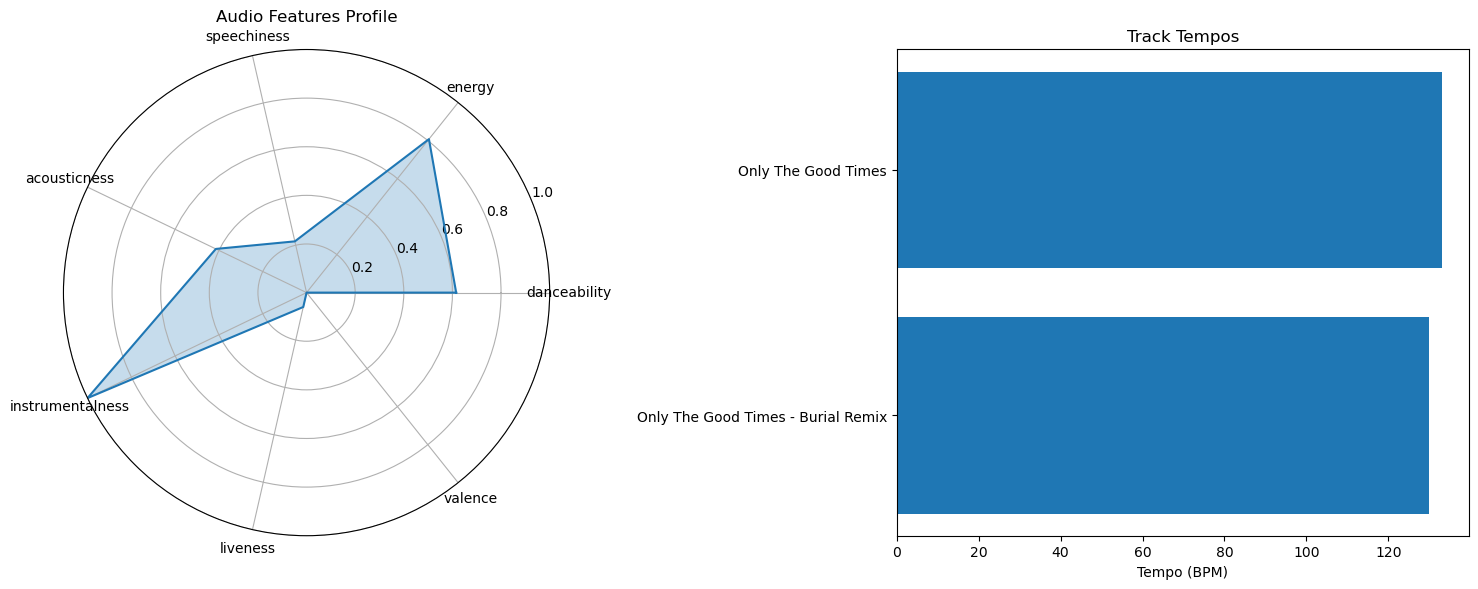


Performing musical analysis...
Average BPM: 131.5
Predominant Key: G#m/Abm

Cluster Analysis:
Primary Cluster: 7

Cluster Characteristics:
- high danceability
- high energy
- high instrumentalness
- high tempo
- high key
- high tempo_normalized

Audio Feature Averages:
Danceability: 0.570
Energy: 0.716
Speechiness: 0.266
Acousticness: 0.417
Instrumentalness: 0.863
Liveness: 0.148
Valence: 0.102

Finding similar tracks...

Input tracks assigned to Cluster 7
Cluster characteristics:
- high danceability
- high energy
- high instrumentalness
- high tempo
- high key
- high tempo_normalized

Recommendation Summary:
Found 5 tracks
Average similarity score: 0.81

Recommendations:

1. outdated_023704 by Kim Changhee
   Style Match: 0.50
   Audio Similarity: 0.95
   Overall Score: 0.81
   Reason: Harmonically compatible; Very similar sound profile; Matching high energy, high instrumentalness

2. Orbital Debris - Denley Remix by Introcut
   Style Match: 0.50
   Audio Similarity: 0.95
   Overall 

In [7]:
# Wrap main execution code with if __name__ == '__main__'
if __name__ == '__main__':
    # Instantiate the recommender
    spotify_client_id = CLIENT_ID
    spotify_client_secret = CLIENT_SECRET
    discogs_token = DISCOGS_TOKEN
    
    recommender = MusicRecommender(spotify_client_id, spotify_client_secret, discogs_token)
    
    # Analyze an album
    url = "https://www.discogs.com/release/30631150-LB-Dub-Corp-X-Burial-Only-The-Good-Times"
    try:
        results = recommender.analyze_album(url)
    except Exception as e:
        print(f"An error occurred during analysis: {e}")